Câncer de próstata ou cancro da próstata, também denominado de carcinoma da próstata, é uma neoplasia que tem seu desenvolvimento na próstata, uma glândula do sistema reprodutor masculino.
Este tipo de câncer se desenvolve mais frequentemente em homens acima dos 50 anos de idade.
Entretanto, muitos homens que desenvolvem câncer de próstata não apresentam sintomas e acabam morrendo por outras causas.

O câncer de próstata é mais frequentemente descoberto através de exame físico ou por monitoração dos exames de sangue, como o teste do "PSA" (sigla em inglês para antígeno prostático específico). Atualmente existe alguma preocupação sobre a acurácia do teste de PSA e sua real utilidade.
A saber, cerca de 20% dos tumores no órgão crescem sem aumentar os níveis da substância no sangue. Portanto, o tumor pode estar presente mesmo em homens com PSA normal.

Para rastreamento, investigação ou com o intuito de confirmar um diagnóstico são realizados exames de imagem.
A ultrassonografia transretal e/ou ressonância magnética são os exames mais utilizados para detecção dos tumores.

Este conjunto de dados é composto por 100 observações e 10 variáveis (das quais 8 variáveis numéricas e uma variável categórica e é ID)

In [1]:
# Fazendo os imports
from __future__ import division, print_function, unicode_literals
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn.linear_model
import urllib.request
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

##from six.moves import urllib


In [2]:
#download dos dados
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/osjonathas/AprendizagemDeMaquina/main/"
LOCALDATAPATH = os.path.join("datasets", "", "")

def fetch_data(url=DOWNLOAD_ROOT, local_path=LOCALDATAPATH):
  if not os.path.isdir(local_path):
    os.makedirs(local_path, exist_ok=True)

  for filename in ("Prostate_Cancer.csv", "Prostate_Cancer.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/" + filename
    urllib.request.urlretrieve(url, LOCALDATAPATH + filename)

#Carregando os dados
def load_data(local_path=LOCALDATAPATH):
  csv_path = os.path.join(local_path, "/content/datasets/Prostate_Cancer.csv")
  return pd.read_csv(csv_path, names=['ID', 'Resultado', 'Raio', 'Textura', 'Perimetro', 'Area', 'Suavidade', 'Compacidade', 'Simetria', 'Dimensao_Fractal'], header=0)



fetch_data(DOWNLOAD_ROOT, LOCALDATAPATH)
df = load_data(LOCALDATAPATH)
df.head()


,ID,Resultado,Raio,Textura,Perimetro,Area,Suavidade,Compacidade,Simetria,Dimensao_Fractal
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059


Utilizando o método head podemos visualizar os cinco primeiros registros do DataFrame.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                100 non-null    int64  
 1   Resultado         100 non-null    object 
 2   Raio              100 non-null    int64  
 3   Textura           100 non-null    int64  
 4   Perimetro         100 non-null    int64  
 5   Area              100 non-null    int64  
 6   Suavidade         100 non-null    float64
 7   Compacidade       100 non-null    float64
 8   Simetria          100 non-null    float64
 9   Dimensao_Fractal  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


Através do método info, é verificado quantidade de registros em cada coluna e os respectivos tipos de dados. Isso nos ajuda a prever a necessidade de manipulações e tratamentos de variáveis.
Tambem nos ajuda a verificar a ausência de valores(null). Uma outra forma de fazer essa verificação é como mostrado a seguir.

In [4]:
nulos = df.isnull().sum()
duplicados = df[df.duplicated()].sum()
display(pd.DataFrame([nulos, duplicados]).T.rename(columns={0:"Nulos",1:"Duplicados"}))

,Nulos,Duplicados
ID,0.0,0.0
Resultado,0.0,0.0
Raio,0.0,0.0
Textura,0.0,0.0
Perimetro,0.0,0.0
Area,0.0,0.0
Suavidade,0.0,0.0
Compacidade,0.0,0.0
Simetria,0.0,0.0
Dimensao_Fractal,0.0,0.0


Aqui avaliamos a existência de colunas vazia como a duplicidade de dados. Como visto, nenhuma das duas ocasiões se aplica a este conjunto de dados.

In [5]:
#Quantificando as categorias: M = Maligno e B = Benígno
df["Resultado"].value_counts()

M    62
B    38
Name: Resultado, dtype: int64

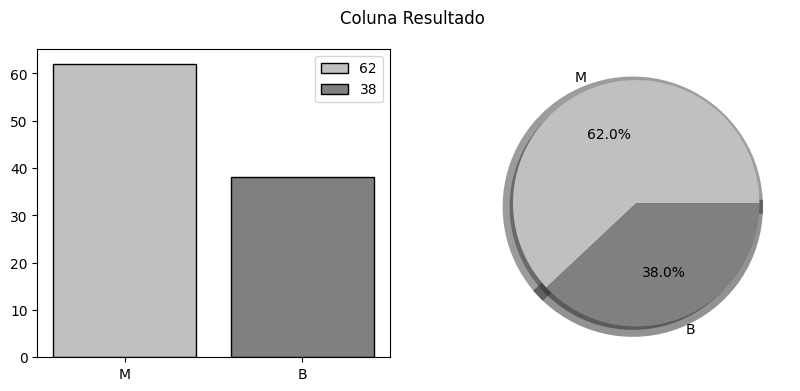

In [6]:
# Verificação de balaceamento das categorias: M = Maligno e B = Benígno
count = df["Resultado"].value_counts().values

fig = plt.figure(figsize=(10,4))
fig.suptitle('Coluna Resultado')

plt.subplot(1,2,1)
plt.bar(["M","B"],count,color=['silver','gray'], label=count, edgecolor = "black")
plt.legend()

plt.subplot(1,2,2)
plt.pie(count, colors=['silver','gray'], labels=["M","B"],autopct="%1.1f%%", shadow=True,wedgeprops = {'linewidth': 10})
plt.show()

In [7]:
df.describe()

,ID,Raio,Textura,Perimetro,Area,Suavidade,Compacidade,Simetria,Dimensao_Fractal
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,29.011492,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,1.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,25.750000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,50.500000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,75.250000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,100.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


Aqui, com o  método muito describe, avaliamos o resumo das variáveis numéricas.
São disponibilizadas informações de medidas de posição, como média, moda e quartis.

In [14]:
# Limpando e Transformando os dados
df = df.drop(columns=['ID'])
dictGender = {"B" : 0, "M" : 1}
df["Resultado"] = df["Resultado"].map(dictGender)

Uma boa prática é excluir colunas desnecessárias e transformar as variáveis categóricas. O modelo obtem melhor performance trabalhando com valores numéricos inteiros do que textos.

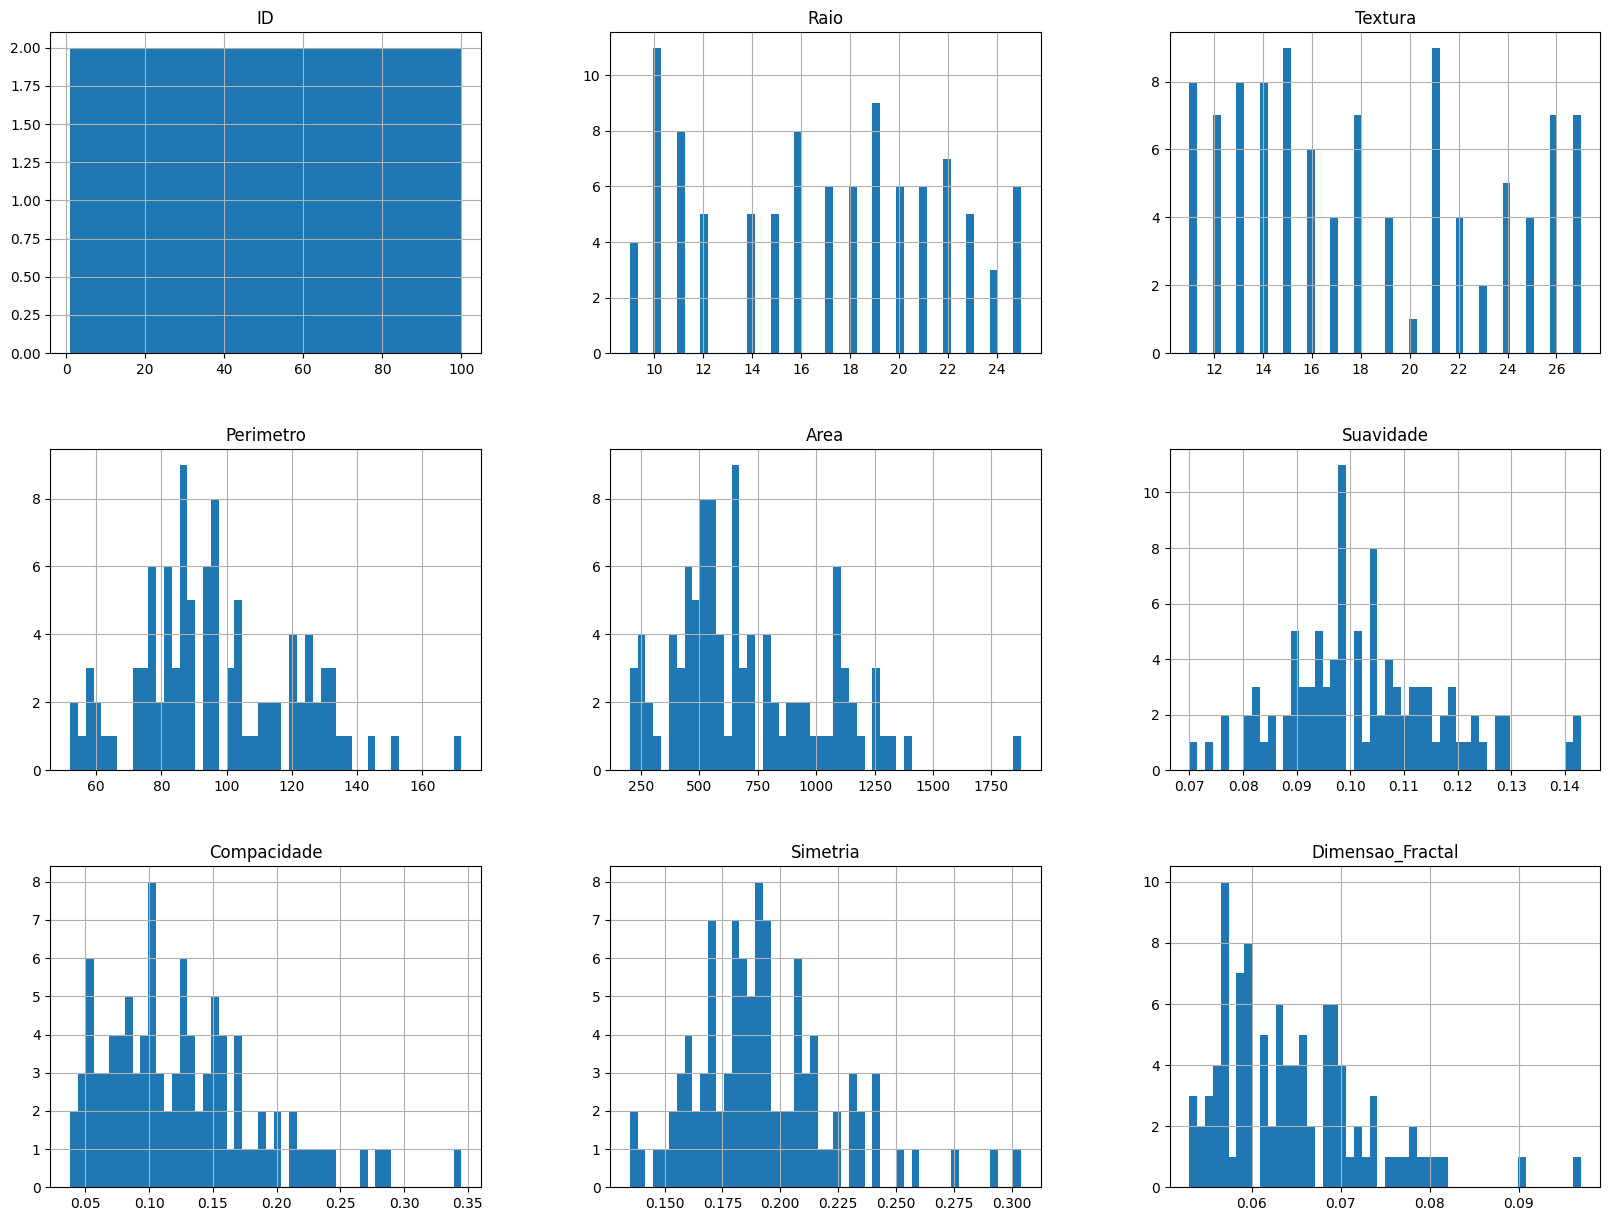

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

<ipython-input-9-af3fb79841c8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacao = df.corr()


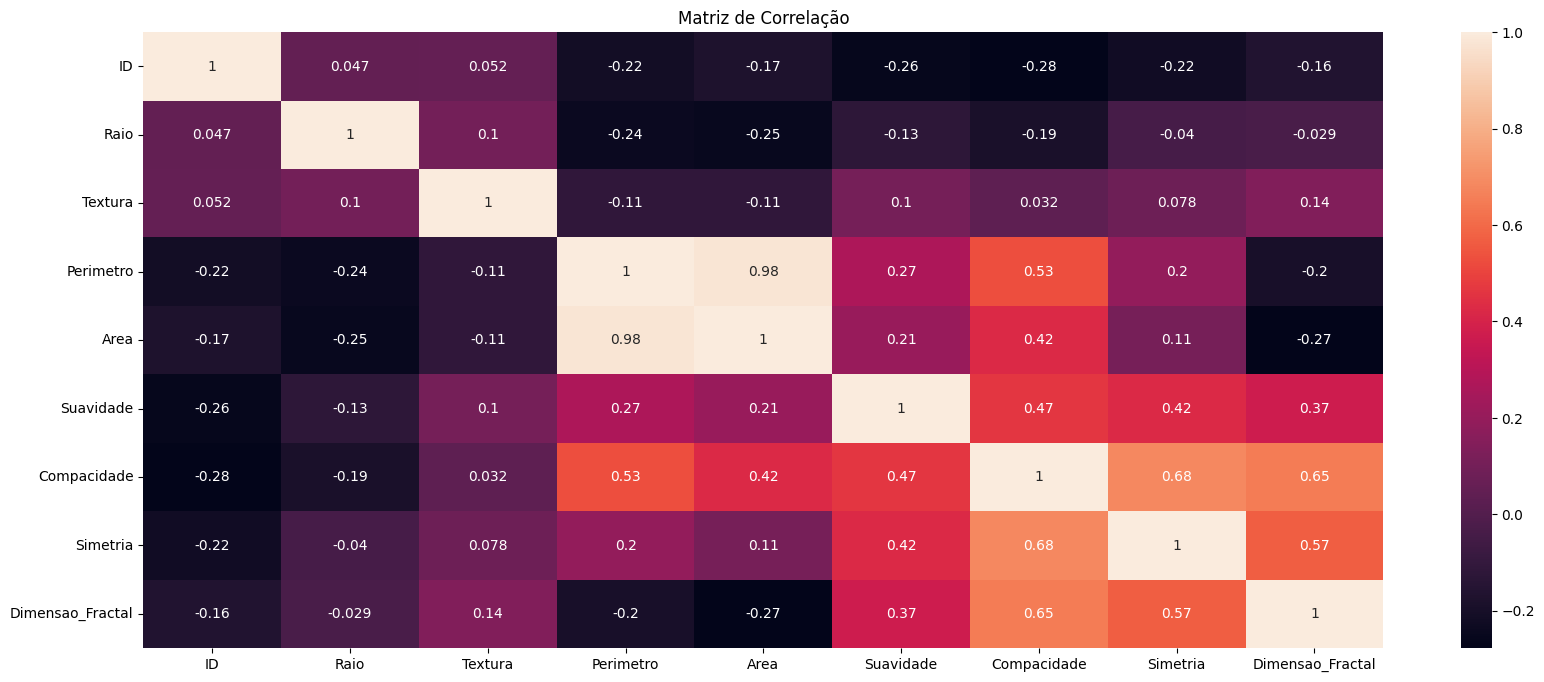

In [9]:
correlacao = df.corr()
plt.figure(figsize=(20,8))
ax = sns.heatmap(correlacao,annot=True)
plt.title("Matriz de Correlação")
plt.show()

In [62]:
# Criando o conjunto de testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
knn = KNeighborsClassifier(n_neighbors = 5)
rf = RandomForestClassifier(random_state = 42)

In [66]:
def predicao(modelo, conjuntos):
  X_train, X_test, y_train, y_test = conjuntos

  #Fitting de Dados e Predição
  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)

  #Calcula as métricas
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  return acc, prec, recall, f1, cm

In [85]:
%%time
MODELOS = { "KNN": knn, "Floresta Aleatória": rf}
INDICADORES = ["accuracy", "precision", "recall", "f1-score"]

#Variáveis para armazenar os resultados
dfResultados = pd.DataFrame(index=INDICADORES,columns=MODELOS.keys())
listMatrix = []

#Execução da rotina de predição
for descricao, modelo in MODELOS.items():
  *dfResultados[descricao] , matrix = predicao(modelo, (X_train, X_test, y_train, y_test))
  listMatrix.append(matrix)

CPU times: user 307 ms, sys: 0 ns, total: 307 ms
Wall time: 468 ms


In [68]:
dfResultados.T.style.highlight_max(color='black')

,accuracy,precision,recall,f1-score
KNN,0.600000,0.571429,0.444444,0.500000
Floresta Aleatória,0.400000,0.384615,0.555556,0.454545


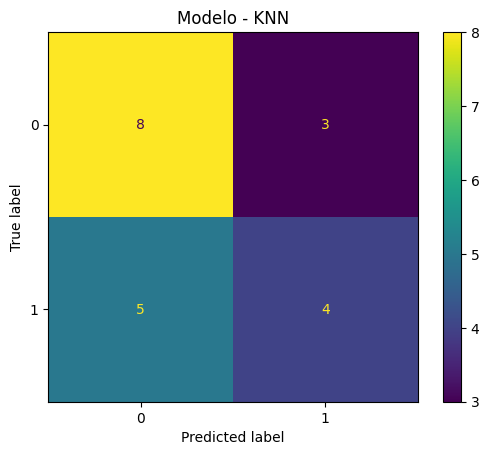

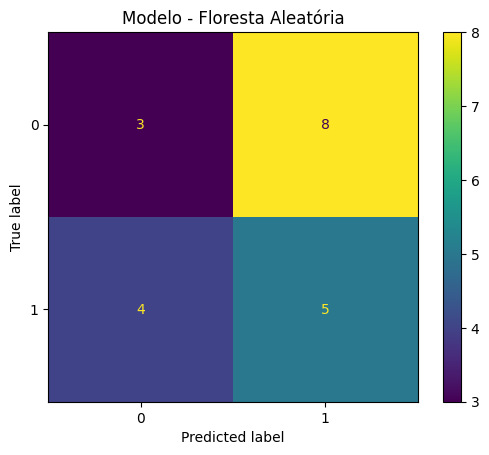

In [73]:
#Matrizes de Confusão
for matrix, descricao in zip(listMatrix , MODELOS.keys()):
  disp = ConfusionMatrixDisplay(matrix)
  disp.plot()
  plt.title(f"Modelo - {descricao}")
  plt.show()

In [94]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#X_train_processed = pipeline.fit_transform(X_train)
#X_test_processed = pipeline.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

params_grid = {
    "loss": ['squared_error', 'huber'],
    "fit_intercept": [True, False],
    "eta0": [0.05, 0.01, 0.1],
    "learning_rate": ["constant", "optimal", "invscaling"]
}

lr_model = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)

grid_search = GridSearchCV(lr_model, params_grid, cv=5, scoring="neg_mean_absolute_percentage_error", return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END eta0=0.05, fit_intercept=True, learning_rate=constant, loss=squared_error;, score=(train=-46366966805480443217639915913216.000, test=-34083699438077441073184434552832.000) total time=   0.0s
[CV 2/5] END eta0=0.05, fit_intercept=True, learning_rate=constant, loss=squared_error;, score=(train=-40750717802114030233848486297600.000, test=-54068341153012615687150405419008.000) total time=   0.0s
[CV 3/5] END eta0=0.05, fit_intercept=True, learning_rate=constant, loss=squared_error;, score=(train=-1572160446699189954063376580608.000, test=-1488424913718239827513757925376.000) total time=   0.0s
[CV 4/5] END eta0=0.05, fit_intercept=True, learning_rate=constant, loss=squared_error;, score=(train=-93083163537014389562428086026240.000, test=-60858328858079255321874414960640.000) total time=   0.0s
[CV 5/5] END eta0=0.05, fit_intercept=True, learning_rate=constant, loss=squared_error;, score=(train=-542251187498968674408

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42),
             param_grid={'eta0': [0.05, 0.01, 0.1],
                         'fit_intercept': [True, False],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_error', 'huber']},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=3)